---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

# Week 6A: Advanced Geospatial Analysis
- Oct 2, 2025

Initialize our packages:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
# import intake
import xarray as xr
import holoviews as hv
import geoviews as gv
from geoviews.tile_sources import EsriImagery

In [2]:
# Ignore numpy runtime warnings
np.seterr("ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Example: Urban heat islands

- We'll reproduce an analysis by Urban Spatial on urban heat islands in Philadelphia using Python.
- The analysis uses Landsat 8 data (2017)
- See: [http://urbanspatialanalysis.com/urban-heat-islands-street-trees-in-philadelphia/](http://urbanspatialanalysis.com/urban-heat-islands-street-trees-in-philadelphia/)

### First load some metadata for Landsat 8

In [3]:
band_info = pd.DataFrame([
        (1,  "Aerosol", " 0.43 - 0.45",    0.440,  "30",         "Coastal aerosol"),
        (2,  "Blue",    " 0.45 - 0.51",    0.480,  "30",         "Blue"),
        (3,  "Green",   " 0.53 - 0.59",    0.560,  "30",         "Green"),
        (4,  "Red",     " 0.64 - 0.67",    0.655,  "30",         "Red"),
        (5,  "NIR",     " 0.85 - 0.88",    0.865,  "30",         "Near Infrared (NIR)"),
        (6,  "SWIR1",   " 1.57 - 1.65",    1.610,  "30",         "Shortwave Infrared (SWIR) 1"),
        (7,  "SWIR2",   " 2.11 - 2.29",    2.200,  "30",         "Shortwave Infrared (SWIR) 2"),
        (8,  "Panc",    " 0.50 - 0.68",    0.590,  "15",         "Panchromatic"),
        (9,  "Cirrus",  " 1.36 - 1.38",    1.370,  "30",         "Cirrus"),
        (10, "TIRS1",   "10.60 - 11.19",   10.895, "100 * (30)", "Thermal Infrared (TIRS) 1"),
        (11, "TIRS2",   "11.50 - 12.51",   12.005, "100 * (30)", "Thermal Infrared (TIRS) 2")],
    columns=['Band', 'Name', 'Wavelength Range (µm)', 'Nominal Wavelength (µm)', 'Resolution (m)', 'Description']).set_index(["Band"])

band_info

Name Wavelength Range (µm)  Nominal Wavelength (µm) Resolution (m)  \
Band                                                                          
1     Aerosol           0.43 - 0.45                    0.440             30   
2        Blue           0.45 - 0.51                    0.480             30   
3       Green           0.53 - 0.59                    0.560             30   
4         Red           0.64 - 0.67                    0.655             30   
5         NIR           0.85 - 0.88                    0.865             30   
6       SWIR1           1.57 - 1.65                    1.610             30   
7       SWIR2           2.11 - 2.29                    2.200             30   
8        Panc           0.50 - 0.68                    0.590             15   
9      Cirrus           1.36 - 1.38                    1.370             30   
10      TIRS1         10.60 - 11.19                   10.895     100 * (30)   
11      TIRS2         11.50 - 12.51                   12.005     100 * (30)   

                      Description  
Band                               
1                 Coastal aerosol  
2                            Blue  
3                           Green  
4                             Red  
5             Near Infrared (NIR)  
6     Shortwave Infrared (SWIR) 1  
7     Shortwave Infrared (SWIR) 2  
8                    Panchromatic  
9                          Cirrus  
10      Thermal Infrared (TIRS) 1  
11      Thermal Infrared (TIRS) 2

### Landsat data on Google Cloud Storage

We'll be downloading publicly available Landsat data from Google Cloud Storage

See: [https://cloud.google.com/storage/docs/public-datasets/landsat](https://cloud.google.com/storage/docs/public-datasets/landsat)

The relevant information is stored in our intake catalog:

From our catalog.yml file:
```
google_landsat_band:
    description: Landsat bands from Google Cloud Storage
    driver: rasterio
    parameters:
      path:
        description: landsat path
        type: int
      row:
        description: landsat row
        type: int
      product_id:
        description: landsat file id
        type: str
      band:
        description: band
        type: int
    args:
      urlpath: https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/{{ '%03d' % path }}/{{ '%03d' % row }}/{{ product_id }}/{{ product_id }}_B{{ band }}.TIF
      chunks:
        band: 1
        x: 256
        y: 256
```

From the "urlpath" above, you can see we need "path", "row", and "product_id" variables to properly identify a Landsat image:

The path and row corresponding to the area over Philadelphia has already been selected using the [Earth Explorer](https://earthexplorer.usgs.gov/). This tool was also used to find the id of the particular date of interest using the same tool.

In [4]:
# Necessary variables
path = 14
row = 32
product_id = 'LC08_L1TP_014032_20160727_20170222_01_T1'

### An alternative: Google Earth Engine (GEE)

- [A public data archive](https://earthengine.google.com/) of satellite imagery going back more than 40 years.
- A Python API exists for pulling data — good resource if you'd like to work with a large amount of raster data

We won't cover the specifics in the course, but [`geemap`](https://geemap.org/) is a fantastic library for interacting with GEE.

- [Landsat data on GEE](https://developers.google.com/earth-engine/datasets/catalog/landsat/)
- [Example notebooks with videos](https://geemap.org/tutorials/)


#### References 

- Google Earth Engine (GEE):
  - [Documentation](https://earthengine.google.com/)
  - [Data Catalog](https://developers.google.com/earth-engine/datasets/catalog)
  - [Landsat data on Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/landsat/)
  - [GEE Guides](https://developers.google.com/earth-engine/guides)
  - [Examples of Python packages for GEE](https://github.com/giswqs/Awesome-GEE#python-api)
- `geemap` package:
  - [Documentation](https://geemap.org/)
  - [GEE tutorials](https://tutorials.geemap.org/)
  - [Example notebooks with videos](https://geemap.org/tutorials/)

### Use a utility function to query the API and request a specific band

This will return a specific Landsat band as a **dask array.**

In [5]:
import requests
import rasterio
import os

# --------------------------
# Scene information
# --------------------------
path = 14
row = 32
product_id = "LC08_L1TP_014032_20160727_20170222_01_T1"

base_url = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01"
bands = list(range(1, 12))  # Landsat 8 has bands 1–11

# Local output folder
os.makedirs("landsat8_bands", exist_ok=True)
local_files = []

# --------------------------
# Download bands
# --------------------------
for b in bands:
    url = f"{base_url}/{path:03d}/{row:03d}/{product_id}/{product_id}_B{b}.TIF"
    local_path = f"landsat8_bands/B{b}.TIF"
    print(f"Checking {url}")

    # if the file already there, skip
    if os.path.exists(local_path): continue
    
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        print(f"✅ Downloading band {b}")
        with open(local_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        local_files.append(local_path)
    else:
        print(f"⚠️ Band {b} not found (status {r.status_code})")

Checking https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/014/032/LC08_L1TP_014032_20160727_20170222_01_T1/LC08_L1TP_014032_20160727_20170222_01_T1_B1.TIF
✅ Downloading band 1
Checking https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/014/032/LC08_L1TP_014032_20160727_20170222_01_T1/LC08_L1TP_014032_20160727_20170222_01_T1_B2.TIF
✅ Downloading band 2
Checking https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/014/032/LC08_L1TP_014032_20160727_20170222_01_T1/LC08_L1TP_014032_20160727_20170222_01_T1_B3.TIF
✅ Downloading band 3
Checking https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/014/032/LC08_L1TP_014032_20160727_20170222_01_T1/LC08_L1TP_014032_20160727_20170222_01_T1_B4.TIF
✅ Downloading band 4
Checking https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/014/032/LC08_L1TP_014032_20160727_20170222_01_T1/LC08_L1TP_014032_20160727_20170222_01_T1_B5.TIF
✅ Downloading band 5
Checking https://storage.googleapis.com/gcp-public

In [6]:
local_files

['landsat8_bands/B1.TIF',
 'landsat8_bands/B2.TIF',
 'landsat8_bands/B3.TIF',
 'landsat8_bands/B4.TIF',
 'landsat8_bands/B5.TIF',
 'landsat8_bands/B6.TIF',
 'landsat8_bands/B7.TIF',
 'landsat8_bands/B8.TIF',
 'landsat8_bands/B9.TIF',
 'landsat8_bands/B10.TIF',
 'landsat8_bands/B11.TIF']

### Stack those downloaded single band tif into multiband GeoTIFF

In [7]:
# --------------------------
# Stack into one multiband GeoTIFF
# --------------------------
stack_path = f"{product_id}_stack.tif"
if local_files:
    # Use metadata from the first band
    with rasterio.open(local_files[0]) as src0:
        meta = src0.meta.copy()
    
    meta.update(count=len(local_files))
    
    with rasterio.open(stack_path, "w", **meta) as dst:
        for idx, file in enumerate(local_files, start=1):
            with rasterio.open(file) as src:
                dst.write(src.read(1), idx)

    print(f"\n🎉 Stacked GeoTIFF written to {stack_path}")
else:
    print("❌ No bands downloaded, nothing to stack")


🎉 Stacked GeoTIFF written to LC08_L1TP_014032_20160727_20170222_01_T1_stack.tif


In [8]:
stack_path

'LC08_L1TP_014032_20160727_20170222_01_T1_stack.tif'

### Load all of the bands and combine them into a single xarray DataArray

Loop over each band, load that band using the above function, and then concatenate the results together..

::: {.callout-important}

CRS for Landsat data is EPSG=32618

:::

In [23]:
path, row, product_id

(14, 32, 'LC08_L1TP_014032_20160727_20170222_01_T1')

In [24]:
def load_google_landsat_metadata(path, row, product_id):
    """
    Load Landsat metadata for path, row, product_id from Google Cloud Storage
    """
    import intake
    
    def parse_type(x):
        try:
            return eval(x)
        except:
            return x
    
    baseurl = "https://storage.googleapis.com/gcp-public-data-landsat/LC08/01"
    suffix = f"{path:03d}/{row:03d}/{product_id}/{product_id}_MTL.txt"
    
    df = intake.open_csv(
        urlpath=f"{baseurl}/{suffix}",
        sep="=",
        header=None,
        names=["index", "value"],
        skiprows=2,
        converters={"index": (lambda x: x.strip()), "value": parse_type},
    
    ).read()
    metadata = df.set_index("index")["value"]
    
    return metadata

In [25]:
metadata = load_google_landsat_metadata(path, row, product_id)
metadata.head(n=20)

index
ORIGIN                         Image courtesy of the U.S. Geological Survey
REQUEST_ID                                              0501702206266_00020
LANDSAT_SCENE_ID                                      LC80140322016209LGN01
LANDSAT_PRODUCT_ID                 LC08_L1TP_014032_20160727_20170222_01_T1
COLLECTION_NUMBER                                                        01
FILE_DATE                                              2017-02-22T04:00:05Z
STATION_ID                                                              LGN
PROCESSING_SOFTWARE_VERSION                                      LPGS_2.7.0
END_GROUP                                                METADATA_FILE_INFO
GROUP                                                      PRODUCT_METADATA
DATA_TYPE                                                              L1TP
COLLECTION_CATEGORY                                                      T1
ELEVATION_SOURCE                                                    GLS2000
OUTPUT

### Use xarray to load the stacked geotiff

In [26]:
import rioxarray as rxr

ds = rxr.open_rasterio(stack_path, masked=True, chunks=True)

In [27]:
print(ds)       # lazy xarray.DataArray

<xarray.DataArray (band: 11, y: 7871, x: 7741)> Size: 3GB
dask.array<open_rasterio-bc7074cd1dc8fa5013bc32c0d33a5106<this-array>, shape=(11, 7871, 7741), dtype=float32, chunksize=(1, 7871, 7741), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 62kB 3.954e+05 3.954e+05 ... 6.276e+05 6.276e+05
  * y            (y) float64 63kB 4.582e+06 4.582e+06 ... 4.346e+06 4.346e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


Here is the extent of the downloaded geotiff. The file size is around **1.3G**. 

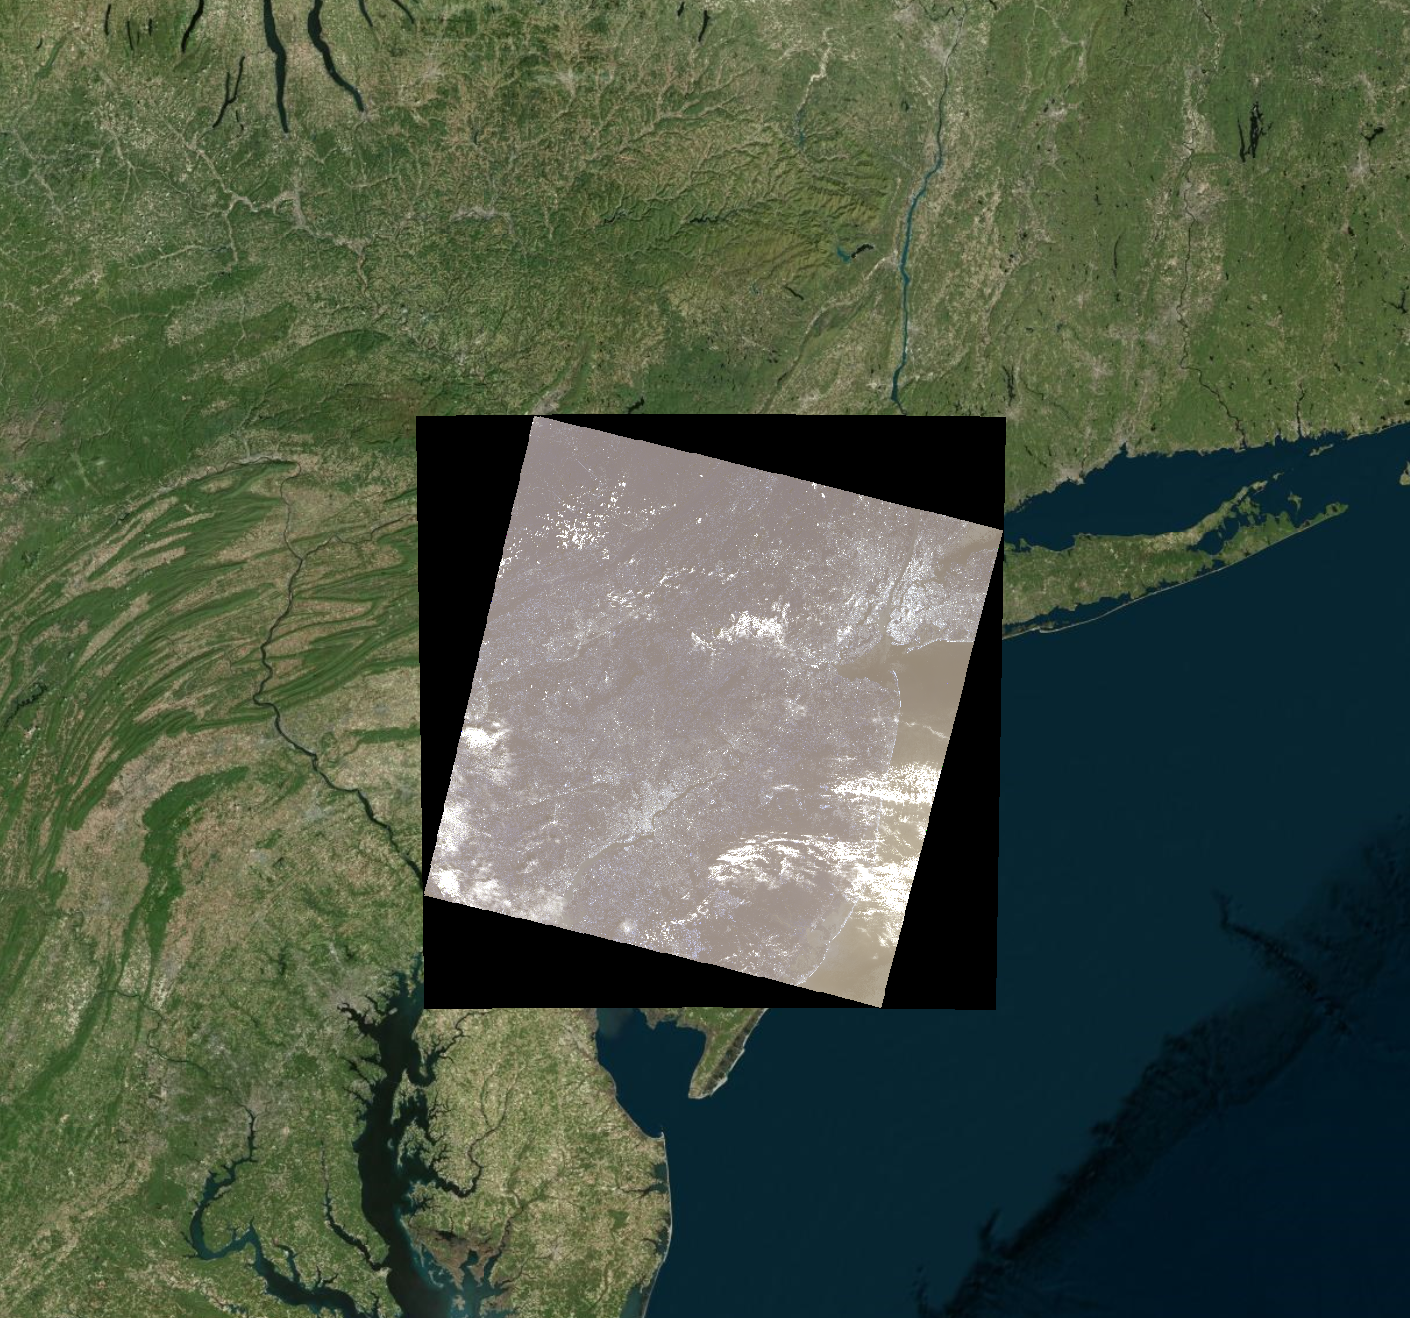{width=400}

### Let's trim our data to the Philadelphia limits

- The Landsat image covers an area much wider than the Philadelphia limits
- We'll load the city limits from Open Data Philly
- Use the `slice()` function discussed last lecture

#### 1. Load the city limits

- From OpenDataPhilly, the city limits for Philadelphia are available at: [http://data.phl.opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson](http://data.phl.opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson)
- Be sure to convert to the same CRS as the Landsat data!

In [28]:
# Load the GeoJSON from the URL
url = "http://data.phl.opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson"
city_limits = gpd.read_file(url)

# Convert to the right CRS for this data
city_limits = city_limits.to_crs(epsg=32618)

#### 2. Use the xmin/xmax and ymin/ymax of the city limits to trim the Landsat DataArray

- Use the built-in slice functionality of xarray
- Remember, the `y` coordinates are in **descending** order, so you'll slice will need to be in descending order as well

In [29]:
# Look up the order of xmin/xmax and ymin/ymax
city_limits.total_bounds?

Type:        property
String form: <property object at 0x1159fb150>
Docstring:  
Return a tuple containing ``minx``, ``miny``, ``maxx``, ``maxy``
values for the bounds of the series as a whole.

See ``GeoSeries.bounds`` for the bounds of the geometries contained in
the series.

Examples
--------
>>> from shapely.geometry import Point, Polygon, LineString
>>> d = {'geometry': [Point(3, -1), Polygon([(0, 0), (1, 1), (1, 0)]),
... LineString([(0, 1), (1, 2)])]}
>>> gdf = geopandas.GeoDataFrame(d, crs="EPSG:4326")
>>> gdf.total_bounds
array([ 0., -1.,  3.,  2.])

In [30]:
# Get x/y range of city limits from "total_bounds"
xmin, ymin, xmax, ymax = city_limits.total_bounds

In [31]:
# Slice our xarray data
# NOTE: y coordinate system is in descending order!
subset = ds.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

In [32]:
subset

<xarray.DataArray (band: 11, y: 1000, x: 924)> Size: 41MB
dask.array<getitem, shape=(11, 1000, 924), dtype=float32, chunksize=(1, 1000, 924), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.038e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### 3. Call the compute() function on your sliced data

- Originally, the Landsat data was stored as dask arrays
- This should now only load the data into memory that covers Philadelphia

In [33]:
subset = subset.compute()

subset

<xarray.DataArray (band: 11, y: 1000, x: 924)> Size: 41MB
array([[[10702., 10162., 10361., ..., 11681., 11489., 15594.],
        [10870., 10376., 10122., ..., 11620., 11477., 12042.],
        [10429., 10147., 10063., ..., 11455., 11876., 11790.],
        ...,
        [11944., 11696., 11626., ..., 11192., 11404., 10923.],
        [12406., 11555., 11155., ..., 11516., 11959., 10766.],
        [11701., 11232., 10657., ..., 10515., 11475., 10926.]],

       [[ 9809.,  9147.,  9390., ..., 10848., 10702., 15408.],
        [ 9989.,  9405.,  9139., ..., 10831., 10660., 11361.],
        [ 9439.,  9083.,  8981., ..., 10654., 11141., 11073.],
        ...,
        [11220., 10853., 10741., ..., 10318., 10511.,  9950.],
        [11765., 10743., 10259., ..., 10646., 11378.,  9829.],
        [10889., 10365.,  9630., ...,  9500., 10573., 10008.]],

       [[ 9042.,  8466.,  8889., ..., 10014.,  9647., 14981.],
        [ 9699.,  8714.,  8596., ...,  9866.,  9783., 11186.],
        [ 8623.,  8457.,  8334., ...,  9688., 10474.,  9993.],
        ...,
...
        [ 5027.,  5028.,  5038., ...,  5035.,  5037.,  5029.],
        [ 5058.,  5021.,  5023., ...,  5035.,  5041.,  5031.],
        [ 5036.,  5041.,  5040., ...,  5036.,  5044.,  5035.]],

       [[29033., 28976., 28913., ..., 32614., 32577., 32501.],
        [28940., 28904., 28858., ..., 32516., 32545., 32545.],
        [28882., 28879., 28854., ..., 32431., 32527., 32563.],
        ...,
        [30094., 29929., 29713., ..., 29521., 29525., 29429.],
        [30140., 29972., 29696., ..., 29556., 29516., 29398.],
        [30133., 29960., 29614., ..., 29587., 29533., 29424.]],

       [[25558., 25519., 25492., ..., 27680., 27650., 27619.],
        [25503., 25450., 25402., ..., 27636., 27630., 27639.],
        [25473., 25434., 25378., ..., 27609., 27668., 27667.],
        ...,
        [26126., 26055., 25934., ..., 25622., 25586., 25520.],
        [26149., 26077., 25935., ..., 25651., 25594., 25507.],
        [26147., 26050., 25856., ..., 25696., 25644., 25571.]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 88B 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.038e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [34]:
# Original data was about 8000 x 8000 in size
ds.shape

(11, 7871, 7741)

In [35]:
# Sliced data is only about 1000 x 1000 in size!
subset.shape

(11, 1000, 924)

### Let's plot band 3 of the Landsat data

In [38]:
# !pip install datashader

In [39]:
import hvplot.pandas   # enables hvplot for pandas & GeoPandas
import hvplot.xarray   # enables hvplot for xarray

# City limits plot
limits_plot = city_limits.hvplot.polygons(
    line_color="white", alpha=0, line_alpha=1, crs=32618, geo=True
)

# Landsat plot
landsat_plot = subset.sel(band=3).hvplot.image(
    x="x",
    y="y",
    rasterize=True,
    cmap="viridis",
    frame_width=500,
    frame_height=500,
    geo=True,
    crs=32618,
)

# Combined
landsat_plot * limits_plot

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


BokehModel(combine_events=True, render_bundle={'docs_json': {'466d8968-ed0a-4165-ac81-ed3f32536656': {'version…

### Calculate the NDVI

Remember, NDVI = (NIR - Red) / (NIR + Red)

In [40]:
band_info.head()

Name Wavelength Range (µm)  Nominal Wavelength (µm) Resolution (m)  \
Band                                                                          
1     Aerosol           0.43 - 0.45                    0.440             30   
2        Blue           0.45 - 0.51                    0.480             30   
3       Green           0.53 - 0.59                    0.560             30   
4         Red           0.64 - 0.67                    0.655             30   
5         NIR           0.85 - 0.88                    0.865             30   

              Description  
Band                       
1         Coastal aerosol  
2                    Blue  
3                   Green  
4                     Red  
5     Near Infrared (NIR)

**NIR is band 5 and Red is band 4**

In [44]:
# Selet the bands we need
NIR = subset.sel(band=5)
RED = subset.sel(band=4)

# Calculate the NDVI
NDVI = (NIR - RED) / (NIR + RED)
NDVI = NDVI.where(NDVI < np.inf)

NDVI.head()

<xarray.DataArray (y: 5, x: 5)> Size: 100B
array([[0.3469071 , 0.43934923, 0.45820224, 0.45798013, 0.3820513 ],
       [0.33747044, 0.40266976, 0.4727623 , 0.44722265, 0.4530777 ],
       [0.407833  , 0.4409327 , 0.47419128, 0.49448025, 0.49341935],
       [0.4019031 , 0.39986497, 0.46889398, 0.48497283, 0.4868614 ],
       [0.47248632, 0.47255626, 0.46365523, 0.37692425, 0.36055776]],
      dtype=float32)
Coordinates:
  * x            (x) float64 40B 4.761e+05 4.761e+05 ... 4.762e+05 4.762e+05
  * y            (y) float64 40B 4.443e+06 4.443e+06 ... 4.443e+06 4.443e+06
    spatial_ref  int64 8B 0

In [45]:
# NEW: Use datashader to plot the NDVI
p = NDVI.hvplot.image(
    x="x",
    y="y",
    geo=True,
    crs=32618,
    datashade=True, # NEW: USE DATASHADER
    project=True, # NEW: PROJECT THE DATA BEFORE PLOTTING
    frame_height=500,
    frame_width=500,
    cmap="viridis",
)

# NEW: Use a transparent rasterized version of the plot for hover text
# No hover text available with datashaded images so we can use the rasterized version
p_hover = NDVI.hvplot(
    x="x",
    y="y",
    crs=32618,
    geo=True,
    rasterize=True,
    frame_height=500,
    frame_width=500,
    alpha=0, # SET ALPHA=0 TO MAKE THIS TRANSPARENT
    colorbar=False,
)

# City limits
limits_plot = city_limits.hvplot.polygons(
    geo=True, crs=32618, line_color="white", line_width=2, alpha=0, line_alpha=1
)

p * p_hover * limits_plot

BokehModel(combine_events=True, render_bundle={'docs_json': {'6ca2066a-2418-4a5c-93eb-644ba886bcb1': {'version…

### A couple of notes

- Notice that we leveraged *datashader* algorithm to plot the NDVI by specifying the `datashade=True` keyword
- Hover tools won't work with datashaded images — instead, we overlaid a *transparent* rasterized version of the image, which shows the mean pixel values across the image

### Now, on to land surface temperature

- Given the NDVI calculated above, we can determine land surface temperature
- But, the data must be cleaned first! Several atmospheric corrections and transformations must be applied.
- We'll use existing an existing package called [rio_toa](https://github.com/mapbox/rio-toa) to do this 

- We'll also need to specify one more for transforming satellite temperature (brightness temp) to land surface temperature. 
- For these calculations we'll use both **Thermal Infrared bands - 10 and 11.**

In [46]:
# !pip install rio_toa

In [47]:
from rio_toa import brightness_temp, toa_utils

In [48]:
def land_surface_temp(BT, w, NDVI):
    """Calculate land surface temperature of Landsat 8
    
    temp = BT/1 + w * (BT /p) * ln(e)
    
    BT = At Satellite temperature (brightness)
    w = wavelength of emitted radiance (μm)
    
    where p = h * c / s (1.439e-2 mK)
    
    h = Planck's constant (Js)
    s = Boltzmann constant (J/K)
    c = velocity of light (m/s)
    
    Land surface emissivity (LSE) is a measure of how effectively a surface emits thermal radiation compared to a perfect blackbody.
	•	It varies with surface type (soil, vegetation, water, etc.).
	•	A common empirical formula is:
    e = 0.986 + 0.004 P_v
    """
    
    h = 6.626e-34
    s = 1.38e-23
    c = 2.998e8

    p = (h * c / s) * 1e6
    
    # (Proportion of Vegetation cover)
    Pv = (NDVI - NDVI.min() / NDVI.max() - NDVI.min()) ** 2
    e = 0.004 * Pv + 0.986
    
    return BT / 1 + w * (BT / p) * np.log(e)

In [49]:

import numpy as np

def brightness_temp(img, ML, AL, K1, K2, src_nodata=0):
    """
    Landsat 8/9 brightness temperature calculation.
    img = digital numbers (DN) array
    ML, AL = radiance rescaling factors
    K1, K2 = thermal constants
    """
    # Radiance
    L = ML * img + AL
    L[img == src_nodata] = np.nan

    # Brightness temperature (Kelvin)
    T = K2 / np.log((K1 / L) + 1)
    return T


def land_surface_temp_for_band(band):
    """
    Utility function to get land surface temperature for a specific band
    """
    # params from general Landsat info
    w = band_info.loc[band]["Nominal Wavelength (µm)"]

    # params from specific Landsat data text file for these images
    ML = metadata[f"RADIANCE_MULT_BAND_{band}"]
    AL = metadata[f"RADIANCE_ADD_BAND_{band}"]
    K1 = metadata[f"K1_CONSTANT_BAND_{band}"]
    K2 = metadata[f"K2_CONSTANT_BAND_{band}"]

    # at_satellite_temp = brightness_temp.brightness_temp(
    #     subset.sel(band=band).values, ML, AL, K1, K2
    # )
    
    at_satellite_temp = brightness_temp(
        subset.sel(band=band).values, ML, AL, K1, K2
    )

    return land_surface_temp(at_satellite_temp, w, NDVI)

#### Get land surface temp for band 10 

In [50]:
# temperature for band 10
band = 10
temp_10 = land_surface_temp_for_band(band).compute()

In [51]:
# convert to Farenheit
temp_10_f = toa_utils.temp_rescale(temp_10, 'F')

In [52]:
temp_10_f

<xarray.DataArray (y: 1000, x: 924)> Size: 7MB
array([[82.91038144, 82.67288906, 82.409878  , ..., 97.35640666,
        97.2117854 , 96.91421684],
       [82.52232388, 82.37220327, 82.18003376, ..., 96.97288603,
        97.08645353, 97.08646979],
       [82.28015277, 82.26777614, 82.16328398, ..., 96.63993145,
        97.01599608, 97.156813  ],
       ...,
       [87.28849526, 86.61320647, 85.72622931, ..., 84.93458774,
        84.95104054, 84.5545339 ],
       [87.47605607, 86.78928099, 85.65633153, ..., 85.07908909,
        84.91395172, 84.42642427],
       [87.44762668, 86.74031197, 85.31875829, ..., 85.20723062,
        84.98407478, 84.53367952]])
Coordinates:
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.038e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B 0

In [53]:
# Save the numpy array as an xarray
band_10 = subset.sel(band=band).copy(data=temp_10_f)

In [54]:
band_10

<xarray.DataArray (y: 1000, x: 924)> Size: 7MB
array([[82.91038144, 82.67288906, 82.409878  , ..., 97.35640666,
        97.2117854 , 96.91421684],
       [82.52232388, 82.37220327, 82.18003376, ..., 96.97288603,
        97.08645353, 97.08646979],
       [82.28015277, 82.26777614, 82.16328398, ..., 96.63993145,
        97.01599608, 97.156813  ],
       ...,
       [87.28849526, 86.61320647, 85.72622931, ..., 84.93458774,
        84.95104054, 84.5545339 ],
       [87.47605607, 86.78928099, 85.65633153, ..., 85.07908909,
        84.91395172, 84.42642427],
       [87.44762668, 86.74031197, 85.31875829, ..., 85.20723062,
        84.98407478, 84.53367952]])
Coordinates:
    band         int64 8B 10
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.038e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Get the land surface temp for band 11

In [55]:
# Get the land surface temp
band = 11
temp_11 = land_surface_temp_for_band(band).compute()

# Convert to Farenheit
temp_11_f = toa_utils.temp_rescale(temp_11, "F")

# Save as an xarray DataArray
band_11 = subset.sel(band=band).copy(data=temp_11_f)

#### Plot both temperatures side-by-side

In [56]:
# plot for band 10
plot_10 = band_10.hvplot.image(
    x="x",
    y="y",
    rasterize=True,
    cmap="fire_r",
    crs=32618,
    geo=True,
    frame_height=400,
    frame_width=400,
    title="Band 10",
)

# plot for band 11
plot_11 = band_11.hvplot.image(
    x="x",
    y="y",
    rasterize=True,
    cmap="fire_r",
    crs=32618,
    geo=True,
    frame_height=400,
    frame_width=400,
    title="Band 11",
)

plot_10 + plot_11

BokehModel(combine_events=True, render_bundle={'docs_json': {'68681928-db29-43c0-9ae8-4d2cab1fdaf7': {'version…

### Plot the final product (the average of the bands)

In [58]:
# Let's average the results of these two bands
mean_temp_f = (band_10 + band_11) / 2

# IMPORTANT: copy over the metadata
mean_temp_f.attrs = band_10.attrs

In [59]:
mean_temp_f

<xarray.DataArray (y: 1000, x: 924)> Size: 7MB
array([[79.40660307, 79.18966598, 78.99007542, ..., 91.86571468,
        91.72090394, 91.49707798],
       [79.07386025, 78.86510826, 78.64784403, ..., 91.56749808,
        91.60979571, 91.63159277],
       [78.8771529 , 78.77252351, 78.57877253, ..., 91.33573037,
        91.66647475, 91.73445198],
       ...,
       [83.01886508, 82.50413466, 81.75841304, ..., 80.57974901,
        80.49729499, 80.1328243 ],
       [83.16974414, 82.64699944, 81.72598193, ..., 80.72493599,
        80.498907  , 80.03605942],
       [83.15060381, 82.55527486, 81.35957853, ..., 80.90230907,
        80.6598026 , 80.25085473]])
Coordinates:
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.038e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [60]:
p = mean_temp_f.hvplot.image(
    x="x",
    y="y",
    rasterize=True,
    crs=32618,
    geo=True,
    frame_width=600,
    frame_height=600,
    cmap="rainbow",
    alpha=0.5,
    legend=False,
    title="Mean Surface Temp (F)"
)

img = p * EsriImagery

img

BokehModel(combine_events=True, render_bundle={'docs_json': {'82d67458-c2d9-40ba-baa6-3444250d8b91': {'version…

### Use the zoom tool to identify hot spots 

**Key insight**: color of the building roof plays a **very** important role in urban heat islands

### Exercise: isolate cold/hot spots on the map

We can use the `.where()` function in xarray to identify the heat islands across the city

**To do:**
- Select only those pixels with mean temperatures about 90 degrees. 
- Remember, the `where()` function takes a boolean array where each pixel is True/False based on the selection criteria
- Use hvplot to plot the imagery for Philadelphia, with the hotspots overlaid

In [61]:
cond = mean_temp_f > 90

In [62]:
hot_spots = mean_temp_f.where(cond)

hot_spots

<xarray.DataArray (y: 1000, x: 924)> Size: 7MB
array([[        nan,         nan,         nan, ..., 91.86571468,
        91.72090394, 91.49707798],
       [        nan,         nan,         nan, ..., 91.56749808,
        91.60979571, 91.63159277],
       [        nan,         nan,         nan, ..., 91.33573037,
        91.66647475, 91.73445198],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.038e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [63]:
hot_spots_plot = hot_spots.hvplot.image(
    x="x",
    y="y",
    cmap="fire",
    crs=32618,
    geo=True,
    frame_height=500,
    frame_width=500,
    colorbar=False,
    legend=False,
    rasterize=True,
    title="Mean Temp (F) > 90",
    alpha=0.7
)


hot_spots_plot * EsriImagery

BokehModel(combine_events=True, render_bundle={'docs_json': {'8c563d56-94b3-453d-99aa-30c550f6ded8': {'version…

### What about cold spots?

Let's select things less than 75 degrees as well...

In [64]:
cold_spots = mean_temp_f.where(mean_temp_f < 75)

In [65]:
cold_spots_plot = cold_spots.hvplot.image(
    x="x",
    y="y",
    cmap="fire",
    geo=True,
    crs=32618,
    frame_height=500,
    frame_width=500,
    colorbar=False,
    legend=False,
    rasterize=True,
    title="Mean Temp (F) < 75",
    alpha=0.5
)


cold_spots_plot * EsriImagery

BokehModel(combine_events=True, render_bundle={'docs_json': {'a66356ac-a40d-4007-9076-0a98fe89ca4b': {'version…

### Cold spots pick out bodies of water and parks / areas of high vegetation!

## Exercise: Exploring the relationship between temperature, trees, and redlining in Philadelphia

In this section, we'll use zonal statistics to calculate the average temperatures for redlined areas and calculate the number of street trees in the city.

### Redlining Readings

- [Redlining and Urban Heat Islands (NYT)](https://www.nytimes.com/interactive/2020/08/24/climate/racism-redlining-cities-global-warming.html)
- [Redlining in Philadelphia](https://controller.phila.gov/philadelphia-audits/mapping-the-legacy-of-structural-racism-in-philadelphia/)
- [Redlining and Street Trees (NYT)](https://www.nytimes.com/interactive/2021/06/30/opinion/environmental-inequity-trees-critical-infrastructure.html)
- [Mapping Inequality: Philadelphia](https://dsl.richmond.edu/panorama/redlining/#city=philadelphia-pa)

### Saving xarray data to a geoTIFF file

- Unfortunately, the zonal statistics calculation requires a rasterio file — so, we will need to to save our mean temperature xarray DataArray to a `.tif` file
- This is not built in to xarray (yet), but we can use the rioxarray package

In [66]:
import rioxarray

In [67]:
# Save to a raster GeoTIFF file!
mean_temp_f.rio.to_raster("./mean_temp_f.tif")

### Part 1: Load the redlined neighborhoods and make an interactive choropleth

- The redlining HOLC map for Philadelphia is available in the `data/` folder
- Use hvplot to make the interactive choropleth map
- Try to match the historical color scheme from the original HOLC categories using the color palette below. 

**Hint**
- Create a new column called `holc_color` in the redlining GeoDataFrame
- You can then specify this column as the color column using the "c=" for `hvplot()`
- To create the column, you can use the `.apply()` function of the `holc_grade` column

In [68]:
color_palette = {
    "A": "#388E3C",
    "B": "#1976D2",
    "C": "#FFEE58",
    "D": "#D32F2F",
    "Commercial": "#a1a1a1",
}

In [69]:
redlining = gpd.read_file("./data/redlining.geojson")

In [70]:
redlining.head()

area_id holc_grade                                           geometry
0        0          A  POLYGON ((-75.17329 40.06201, -75.17572 40.060...
1        1          A  MULTIPOLYGON (((-75.19831 40.05021, -75.19899 ...
2        2          A  POLYGON ((-75.1281 40.04734, -75.12844 40.0456...
3        3          A  POLYGON ((-75.11494 40.03443, -75.13476 40.036...
4        4          A  POLYGON ((-75.18377 40.02725, -75.17894 40.023...

In [71]:
colors = redlining['holc_grade'].replace(color_palette)

In [72]:
colors.head()

0    #388E3C
1    #388E3C
2    #388E3C
3    #388E3C
4    #388E3C
Name: holc_grade, dtype: object

In [73]:
redlining["holc_color"] = colors

In [74]:
holc_map = redlining.hvplot.polygons(
    c="holc_color",
    frame_width=400,
    frame_height=400,
    geo=True,
    hover_cols=["holc_grade"],
    alpha=0.5
) 

holc_map * gv.tile_sources.ESRI

:Overlay
   .Polygons.I :Polygons   [Longitude,Latitude]   (holc_color,holc_grade)
   .WMTS.I     :WMTS   [Longitude,Latitude]

### Part 2: Calculate the mean temperature for each redlined area

- Use `rasterio.open()` to load the mean temp TIFF file
- Use the `rasterstats` package to calculate the zonal stats
- Look back at week 5's lecture for help!
- Make sure the CRS matches!

In [76]:
from rasterstats import zonal_stats
import rasterio as rio

In [77]:
# Open the GeoTIFF file using rasterio
f = rio.open('./mean_temp_f.tif')
f

<open DatasetReader name='./mean_temp_f.tif' mode='r'>

Load the data from the file:

In [78]:
temp_data = f.read(1)

temp_data

array([[79.40660307, 79.18966598, 78.99007542, ..., 91.86571468,
        91.72090394, 91.49707798],
       [79.07386025, 78.86510826, 78.64784403, ..., 91.56749808,
        91.60979571, 91.63159277],
       [78.8771529 , 78.77252351, 78.57877253, ..., 91.33573037,
        91.66647475, 91.73445198],
       ...,
       [83.01886508, 82.50413466, 81.75841304, ..., 80.57974901,
        80.49729499, 80.1328243 ],
       [83.16974414, 82.64699944, 81.72598193, ..., 80.72493599,
        80.498907  , 80.03605942],
       [83.15060381, 82.55527486, 81.35957853, ..., 80.90230907,
        80.6598026 , 80.25085473]])

Same as:

In [79]:
mean_temp_f.values

array([[79.40660307, 79.18966598, 78.99007542, ..., 91.86571468,
        91.72090394, 91.49707798],
       [79.07386025, 78.86510826, 78.64784403, ..., 91.56749808,
        91.60979571, 91.63159277],
       [78.8771529 , 78.77252351, 78.57877253, ..., 91.33573037,
        91.66647475, 91.73445198],
       ...,
       [83.01886508, 82.50413466, 81.75841304, ..., 80.57974901,
        80.49729499, 80.1328243 ],
       [83.16974414, 82.64699944, 81.72598193, ..., 80.72493599,
        80.498907  , 80.03605942],
       [83.15060381, 82.55527486, 81.35957853, ..., 80.90230907,
        80.6598026 , 80.25085473]])

In [80]:
f.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]')

In [81]:
# Get the CRS
CRS = f.crs.to_epsg()
print(CRS)

32618


In [82]:
#  Get the transform too
transform = f.transform

In [83]:
# Use zonal_stats to get the mean temperature values within each redlined area
# FIRST ARGUMENT: vector polygons
# SECOND ARGUMENT: mean temperature raster data
redlining_stats = zonal_stats(
    redlining.to_crs(epsg=CRS), 
    mean_temp_f.values, 
    affine=transform, 
    nodata=np.nan
)

# Converts stats to a dataframe
redlining_stats = pd.DataFrame(redlining_stats)

redlining_stats.head()

min        max       mean  count
0  76.010951  85.733335  81.404053   1731
1  73.233313  88.181813  77.454272   7074
2  78.859198  88.117633  82.955856   1639
3  76.951035  95.523826  87.346343   2150
4  74.435373  89.863417  79.952737   1717

In [84]:
### ALTERNATIVE
### in this case, you don't need to specify the transform,
### it's loaded from the TIF file

redlining_stats = zonal_stats(redlining.to_crs(epsg=CRS), "./mean_temp_f.tif")

# Converts stats to a dataframe
redlining_stats = pd.DataFrame(redlining_stats)

/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [85]:
# Store the mean temp back in the original redlining dataframe
redlining["mean_temp"] = redlining_stats['mean']

In [86]:
redlining.head()

area_id holc_grade                                           geometry  \
0        0          A  POLYGON ((-75.17329 40.06201, -75.17572 40.060...   
1        1          A  MULTIPOLYGON (((-75.19831 40.05021, -75.19899 ...   
2        2          A  POLYGON ((-75.1281 40.04734, -75.12844 40.0456...   
3        3          A  POLYGON ((-75.11494 40.03443, -75.13476 40.036...   
4        4          A  POLYGON ((-75.18377 40.02725, -75.17894 40.023...   

  holc_color  mean_temp  
0    #388E3C  81.404053  
1    #388E3C  77.454272  
2    #388E3C  82.955856  
3    #388E3C  87.346343  
4    #388E3C  79.952737

### Part 3: Use hvplot to plot a choropleth of the mean temperature 

- Make a two panel chart with the redlined areas on the right and the mean temperature on the left
- To quickly let us see which areas are hotter or colder than the citywide average, subtract out the mean temperature of the entire city

**Hint**
- You can use the `np.nanmean()` function to calculate the mean of the temperature raster data, automatically ignoring any NaN pixels
- Use a diverging color palette to visualize the difference from the citywide average

In [87]:
mean_temp_f.values

array([[79.40660307, 79.18966598, 78.99007542, ..., 91.86571468,
        91.72090394, 91.49707798],
       [79.07386025, 78.86510826, 78.64784403, ..., 91.56749808,
        91.60979571, 91.63159277],
       [78.8771529 , 78.77252351, 78.57877253, ..., 91.33573037,
        91.66647475, 91.73445198],
       ...,
       [83.01886508, 82.50413466, 81.75841304, ..., 80.57974901,
        80.49729499, 80.1328243 ],
       [83.16974414, 82.64699944, 81.72598193, ..., 80.72493599,
        80.498907  , 80.03605942],
       [83.15060381, 82.55527486, 81.35957853, ..., 80.90230907,
        80.6598026 , 80.25085473]])

In [88]:
# Nan values cause this to not be defined!
mean_temp_f.values.mean()

81.7015832845281

In [89]:
citywide_mean_temp = np.nanmean(mean_temp_f.values) # use nanmean() to skip NaN pixels automatically!
redlining['mean_temp_normalized'] = redlining['mean_temp'] - citywide_mean_temp

In [90]:
citywide_mean_temp

81.7015832845281

In [91]:
choro = redlining.hvplot(
    c="mean_temp_normalized",
    frame_width=400,
    frame_height=400,
    geo=True,
    hover_cols=["holc_grade", 'mean_temp'],
    alpha=0.5,
    cmap='coolwarm',
) 


choro * gv.tile_sources.ESRI  + holc_map * gv.tile_sources.ESRI 

:Layout
   .Overlay.I  :Overlay
      .Polygons.I :Polygons   [Longitude,Latitude]   (mean_temp_normalized,holc_grade,mean_temp)
      .WMTS.I     :WMTS   [Longitude,Latitude]
   .Overlay.II :Overlay
      .Polygons.I :Polygons   [Longitude,Latitude]   (holc_color,holc_grade)
      .WMTS.I     :WMTS   [Longitude,Latitude]

### Part 4: Calculate the average temp by HOLC grade

Use a groupby / mean operation to calculate the mean tempeature for eah HOLC grade, e.g., A, B, C, etc.

**You should find that better HOLC grades correspond to lower mean temperatures**

In [111]:
redlining.groupby("holc_grade")["mean_temp"].mean().sort_values()

holc_grade
A             82.365140
B             84.636956
C             86.298799
D             86.306135
Commercial    86.754481
Name: mean_temp, dtype: float64